In [236]:
from typing import Tuple
import numpy as np
import deepgp
import matplotlib.pyplot as plt
from datetime import datetime
import os

import GPy
from GPy.models import GPRegression
from emukit.test_functions import forrester_function
from emukit.core.initial_designs import RandomDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement, EntropySearch
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from gpflow.kernels import RBF, White, Linear
from tqdm import tqdm

from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

In [10]:
def plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis):
    axis.plot(X, Y, "ro", markersize=10, label="Observations")
    axis.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    axis.legend(loc=2, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [223]:
def plot_acquisition_functions(x_plot, ac_plot, x_new, axis):
    axis.plot(x_plot, (ac_plot[1] - np.min(ac_plot[1])) / (np.max(ac_plot[1]) - np.min(ac_plot[1])), label=ac_plot[0])
    #axis.plot(x_plot, (ac_plots[0][1] - np.min(ac_plots[0][1])) / (np.max(ac_plots[0][1]) - np.min(ac_plots[0][1])), label=ac_plots[0][0])
    #axis.plot(x_plot, (ac_plots[1][1] - np.min(ac_plots[1][1])) / (np.max(ac_plots[1][1]) - np.min(ac_plots[1][1])), label=ac_plots[1][0])
    #axis.plot(x_plot, (ac_plots[2][1] - np.min(ac_plots[2][1])) / (np.max(ac_plots[2][1]) - np.min(ac_plots[2][1])), label=ac_plots[2][0])
    #axis.plot(x_plot, (ac_plots[3][1] - np.min(ac_plots[3][1])) / (np.max(ac_plots[3][1]) - np.min(ac_plots[3][1])), label=ac_plots[3][0])

    axis.axvline(x_new, color="red", label="x_next", linestyle="--")
    axis.legend(loc=1, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [29]:
import statistics

def target_function_list(X, repetition=10):
    Y = []
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        # items = []
        total = 0
        for i in range(repetition):
            days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
                period=10, should_display_day=False, should_display_grid=False, should_display_traits=False), max_days=10000)
            #items.append(days_survived)
            total += days_survived
        #Y.append(statistics.median(items))
        Y.append(total//repetition)
    return np.array(Y)[:,np.newaxis]

In [264]:
# Generate the initial points to start the training process

def experiment_initialisation(space, num_data_points = 5):
    design = RandomDesign(space) # Collect random points
    X = design.get_samples(num_data_points)
    Y = target_function_list(X)
    return X, Y

In [265]:
def model_generation(X, Y, space, kernel = None):
    if kernel is None:
        kernel_rbf_1 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[0])
        kernel_rbf_2 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[1])
        kernel_rbf_3 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[2])
        kernel_rbf_4 = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=1, active_dims=[3])
        kernel = kernel_rbf_1 + kernel_rbf_2 + kernel_rbf_3 + kernel_rbf_4
    model_gpy = GPRegression(X,Y,kernel, noise_var=1) # Train and wrap the model in Emukit
    model_emukit = GPyModelWrapper(model_gpy)
    return model_emukit

In [266]:
iterations = 1000
# The other mutation rates for the projection
projection = 0
# Along which trait is the function plotted: 0-size, 1-speed, 2-vision, 3-aggression
plot = 0

# returns the mean square error history of the iterations
def train(modol_emukit, X, Y, space, acquisition, iterations = 1000, plot = 0, projection = 0):

    file_path = 'training_logs/plot_' + str(plot) + '_projection_' + str(projection) + '_' + str(datetime.now())
    os.makedirs(file_path)
    figure, axis = plt.subplots(1, 2, figsize=(20, 6))
    x_plot = np.linspace(0, 1, 1000)[:, None]
    x_paddings = np.linspace(projection, projection, 1000)[:, None]
    x_linear = np.linspace(0, 1, 1000)[:, None]

    history = []
    with open('dataset_test/mutation_rates.npy', 'rb') as f:
      X_test = np.load(f)
    with open('dataset_test/simulated_years_of_survival.npy', 'rb') as f:
      y_test = np.load(f)

    for j in range(plot):
        x_plot = np.append(x_paddings, x_plot, axis = 1)
    for j in range(3-plot):
        x_plot = np.append(x_plot, x_paddings, axis = 1)
    
    for i in tqdm(range(iterations)):
            
        mu_plot, var_plot = model_emukit.predict(x_plot)
        plot_prediction(X[:,plot],Y,x_linear,mu_plot,var_plot,axis[0])

        predictions, _ = model_emukit.predict(X_test)
        history.append(np.square(y_test - predictions).mean())
        
        ac_plot = ("AF", acquisition.evaluate(x_plot))
        
        optimizer = GradientAcquisitionOptimizer(space)
        x_new, _ = optimizer.optimize(acquisition)

        plot_acquisition_functions(x_linear, ac_plot, x_new[0][plot], axis[1])
        print("Next position to query:", x_new)
        acquisition.debug(np.array(x_new))
        y_new = target_function_list(x_new)
        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)
        print(x_new, y_new)
        model_emukit.set_data(X, Y)
        plt.savefig(file_path + '/' + str(i) +'.png')
        plt.clf()
        figure, axis = plt.subplots(1, 2, figsize=(20, 6))
        with open(file_path + '/history.npy', 'wb') as f:
            np.save(f, np.array(history))
    return history

In [60]:
def sensitivity_2d(X, sensitivity, x_a=0, y_a=1, projection = 0):
    results = []
    for x in X:
        point = np.array([projection, projection, projection, projection])
        point[x_a] = x[0]
        point[y_a] = x[1]
        results.append(sensitivity.compute_statistics(point)[0])
    return np.array(results)

In [ ]:
sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)

In [251]:
def plot_sensitivity_2d(model_emukit, x_a=0, y_a=1, projection = 0):
    space = ParameterSpace([ContinuousParameter('size', 0, 1),
                        ContinuousParameter('speed', 0, 1),
                        ContinuousParameter('vision', 0, 1),
                        ContinuousParameter('aggression', 0, 1)])
    
    sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
    main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)
    
    x_axis = np.linspace(0, 1, 100)
    y_axis = np.linspace(0, 1, 100)
    
    X_axis,Y_axis = np.meshgrid(x_axis, y_axis)
    data = np.vstack([X_axis.ravel(), Y_axis.ravel()])
    data = np.swapaxes(data,0,-1)
    
    plt.figure(figsize=(8,6))
    plt.contourf(X_axis, Y_axis, sensitivity_2d(data, sensitivity, x_a, y_a, projection).reshape(X_axis.shape), levels=20)
    plt.colorbar()
    return main_effects, total_effects

In [ ]:
space = ParameterSpace([ContinuousParameter('size', 0, 1),
                            ContinuousParameter('speed', 0, 1),
                            ContinuousParameter('vision', 0, 1),
                            ContinuousParameter('aggression', 0, 1)])
X, Y = experiment_initialisation(space,20)
model = model_generation(X, Y, space)
ce_acquisition = CrossEntropy(model,space)
es_history = train(model, X, Y, space, ce_acquisition, 10000)

  0%|                                                                                                                                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

Next position to query: [[1.         0.88392653 0.76258581 0.90774858]]
[135.73512881] [1.69631895] [396.36481333] [94.96205269]
[[1.         0.88392653 0.76258581 0.90774858]] [[204]]


  0%|                                                                                                                                                                                                                                                                                  | 1/10000 [00:18<50:07:31, 18.05s/it]

Next position to query: [[1.        0.8844243 1.        1.       ]]
[94.78590786] [1.88819358] [392.74420309] [96.15506962]
[[1.        0.8844243 1.        1.       ]] [[238]]


  0%|                                                                                                                                                                                                                                                                                  | 2/10000 [00:37<51:59:26, 18.72s/it]

Next position to query: [[1. 0. 1. 1.]]
[131.24126333] [1.93314643] [387.69441766] [98.94415029]
[[1. 0. 1. 1.]] [[134]]


  0%|                                                                                                                                                                                                                                                                                  | 3/10000 [00:49<43:52:48, 15.80s/it]

Next position to query: [[1.         0.88392631 0.7625859  0.90774878]]
[135.73512232] [1.69631906] [396.36481299] [94.96205528]
[[1.         0.88392631 0.7625859  0.90774878]] [[229]]


  0%|                                                                                                                                                                                                                                                                                  | 4/10000 [01:08<47:15:10, 17.02s/it]

Next position to query: [[1. 0. 0. 1.]]
[112.34375238] [1.90344091] [385.27391838] [97.48022726]
[[1. 0. 0. 1.]] [[94]]


  0%|▏                                                                                                                                                                                                                                                                                 | 5/10000 [01:18<40:25:31, 14.56s/it]

Next position to query: [[1.         0.88489701 0.         0.91808203]]
[76.79769364] [1.81900989] [388.88059077] [94.60458851]
[[1.         0.88489701 0.         0.91808203]] [[132]]


  0%|▏                                                                                                                                                                                                                                                                                 | 6/10000 [01:32<39:33:00, 14.25s/it]

Next position to query: [[1. 0. 1. 1.]]
[131.24126333] [1.93314643] [387.69441766] [98.94415029]
[[1. 0. 1. 1.]] [[120]]


  0%|▏                                                                                                                                                                                                                                                                                 | 7/10000 [01:43<37:13:32, 13.41s/it]

Next position to query: [[1.         0.88442669 1.         0.91426608]]
[95.74498545] [1.89118231] [393.25452703] [95.84143794]
[[1.         0.88442669 1.         0.91426608]] [[202]]


  0%|▏                                                                                                                                                                                                                                                                                 | 8/10000 [02:01<40:52:36, 14.73s/it]

Next position to query: [[1.         0.88442428 1.         1.        ]]
[94.7859078] [1.88819359] [392.7442032] [96.15506968]
[[1.         0.88442428 1.         1.        ]] [[199]]


  0%|▏                                                                                                                                                                                                                                                                                 | 9/10000 [02:18<42:37:04, 15.36s/it]

Next position to query: [[1.         0.88442669 1.         0.91426607]]
[95.74498546] [1.89118231] [393.2545271] [95.84143796]
[[1.         0.88442669 1.         0.91426607]] [[240]]


  0%|▎                                                                                                                                                                                                                                                                                | 10/10000 [02:37<46:17:50, 16.68s/it]

Next position to query: [[1.         0.8844268  1.         0.91426584]]
[95.74498962] [1.89118236] [393.25452745] [95.84143659]
[[1.         0.8844268  1.         0.91426584]] [[242]]


  0%|▎                                                                                                                                                                                                                                                                                | 11/10000 [02:57<48:44:29, 17.57s/it]

Next position to query: [[1.         0.88489711 0.         0.91808186]]
[76.79769651] [1.81900991] [388.88059051] [94.60458747]
[[1.         0.88489711 0.         0.91808186]] [[139]]


  0%|▎                                                                                                                                                                                                                                                                                | 12/10000 [03:11<45:37:23, 16.44s/it]

Next position to query: [[1.         0.88442669 1.         0.91426613]]
[95.7449846] [1.89118229] [393.25452683] [95.84143817]
[[1.         0.88442669 1.         0.91426613]] [[206]]


  0%|▎                                                                                                                                                                                                                                                                                | 13/10000 [03:28<46:24:01, 16.73s/it]

Next position to query: [[1.        0.8844243 1.        1.       ]]
[94.78590785] [1.88819358] [392.7442031] [96.15506963]
[[1.        0.8844243 1.        1.       ]] [[212]]


  0%|▍                                                                                                                                                                                                                                                                                | 14/10000 [03:46<47:19:57, 17.06s/it]

Next position to query: [[1.         0.88442668 1.         0.91426598]]
[95.74498693] [1.89118236] [393.25452764] [95.84143763]
[[1.         0.88442668 1.         0.91426598]] [[221]]


  0%|▍                                                                                                                                                                                                                                                                                | 15/10000 [04:04<48:17:53, 17.41s/it]

Next position to query: [[1. 0. 0. 1.]]
[112.34375238] [1.90344091] [385.27391838] [97.48022726]
[[1. 0. 0. 1.]] [[93]]


  0%|▍                                                                                                                                                                                                                                                                                | 16/10000 [04:15<42:52:21, 15.46s/it]

Next position to query: [[1.         0.45167657 0.         0.92864103]]
[113.0681686] [1.71251663] [388.40387035] [96.57711836]
[[1.         0.45167657 0.         0.92864103]] [[174]]


  0%|▍                                                                                                                                                                                                                                                                                | 17/10000 [04:32<43:33:20, 15.71s/it]

Next position to query: [[0.5999434  0.88512176 0.         0.92952769]]
[119.24085572] [1.76083878] [382.53843478] [95.37624734]
[[0.5999434  0.88512176 0.         0.92952769]] [[162]]


  0%|▍                                                                                                                                                                                                                                                                                | 18/10000 [04:47<43:46:30, 15.79s/it]

Next position to query: [[1.         0.88442879 1.         0.91426613]]
[95.7449932] [1.89118143] [393.25451163] [95.84142963]
[[1.         0.88442879 1.         0.91426613]] [[230]]


  0%|▌                                                                                                                                                                                                                                                                                | 19/10000 [05:10<49:19:53, 17.79s/it]

Next position to query: [[1.         0.88489721 0.         0.91808158]]
[76.79770069] [1.81900998] [388.88059025] [94.60458598]
[[1.         0.88489721 0.         0.91808158]] [[136]]


 /var/folders/8p/rl0cc1cx5h5301dxt0kcg54h0000gn/T/ipykernel_35240/2906769057.py:51: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  0%|▌                                                                                                                                                                                                                                                                              | 20/10000 [22:08<882:00:33, 318.16s/it]

Next position to query: [[1. 0. 0. 1.]]
[112.34375238] [1.90344091] [385.27391838] [97.48022726]
[[1. 0. 0. 1.]] [[95]]


  0%|▌                                                                                                                                                                                                                                                                              | 21/10000 [22:24<630:39:56, 227.52s/it]

Next position to query: [[1.         0.88482703 0.         1.        ]]
[75.89087917] [1.81811935] [388.79845927] [94.90040249]


In [268]:
file_path = 'training_logs/plot_0_projection_0_2024-01-15 10:38:31.085964'
with open(file_path + '/history.npy', 'rb') as f:
    history = np.load(f)

In [269]:
x = np.array([i for i in range(len(history))])

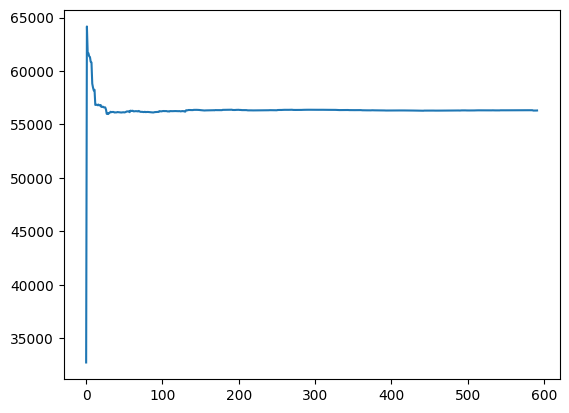

In [270]:
plt.plot(history)

In [85]:
import pickle
with open(file_path+'/model.pkl', 'wb') as outp:
    pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [233]:
import numpy as np
import scipy.stats
from typing import Tuple, Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IDifferentiable, IJointlyDifferentiable, IModel, IModelWithNoise


class CrossEntropy(Acquisition):
    def __init__(self, model: Union[IModel, IDifferentiable],space: ParameterSpace, jitter: float = 0.0) -> None:
        """
        For a given input, this acquisition computes the improvement over the current best observed value in
        expectation. For more information see:

        Efficient Global Optimization of Expensive Black-Box Functions
        Jones, Donald R. and Schonlau, Matthias and Welch, William J.
        Journal of Global Optimization

        :param model: model that is used to compute the improvement.
        :param jitter: parameter to encourage extra exploration.
        """

        self.model = model
        self.jitter = jitter
        self.space = space

    def evaluate(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]
            observed_mu = (np.sqrt(np.sum((model.X-x)**2,axis=-1))/(np.sqrt(np.sum((model.X-x)**2,axis=-1))).sum()).dot(model.Y)
            observed_x2 = (np.sqrt(np.sum((model.X-x)**2,axis=-1))/(np.sqrt(np.sum((model.X-x)**2,axis=-1))).sum()).dot(model.Y**2)
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            # print(predicted_mu, predicted_std, observed_mu, observed_std)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)

    def debug(self, X: np.ndarray) -> np.ndarray:
        ces = []
        for x in X:
            #print(x.shape,x)
            predicted_mu, predicted_var = model.predict(np.array([x]))
            predicted_mu = predicted_mu[0]
            predicted_var = predicted_var[0]
            observed_mu = (np.sqrt(np.sum((model.X-x)**2,axis=-1))/(np.sqrt(np.sum((model.X-x)**2,axis=-1))).sum()).dot(model.Y)
            observed_x2 = (np.sqrt(np.sum((model.X-x)**2,axis=-1))/(np.sqrt(np.sum((model.X-x)**2,axis=-1))).sum()).dot(model.Y**2)
            observed_std = np.sqrt(observed_x2-observed_mu**2)
            predicted_std = np.sqrt(predicted_var)
            print(predicted_mu, predicted_std, observed_mu, observed_std)
            temp = np.linspace(0, 1000, 1000)
            pk = scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std)/scipy.stats.norm.pdf(temp, loc=predicted_mu, scale=predicted_std).sum()
            qk = scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std)/scipy.stats.norm.pdf(temp, loc=observed_mu, scale=observed_std).sum()
            ce = entropy(pk, base=2) + entropy(pk, qk, base=2)
            ces.append([ce])
        return np.array(ces)


    @property
    def has_gradients(self) -> bool:
        """Returns that this acquisition has gradients"""
        return False

    def _get_model_predictions(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Get model predictions for the function values at given input locations."""
        return self.model.predict(x)

    def _get_y_minimum(self) -> np.ndarray:
        """Return the minimum value in the samples observed so far."""
        return np.min(self.model.Y, axis=0)
